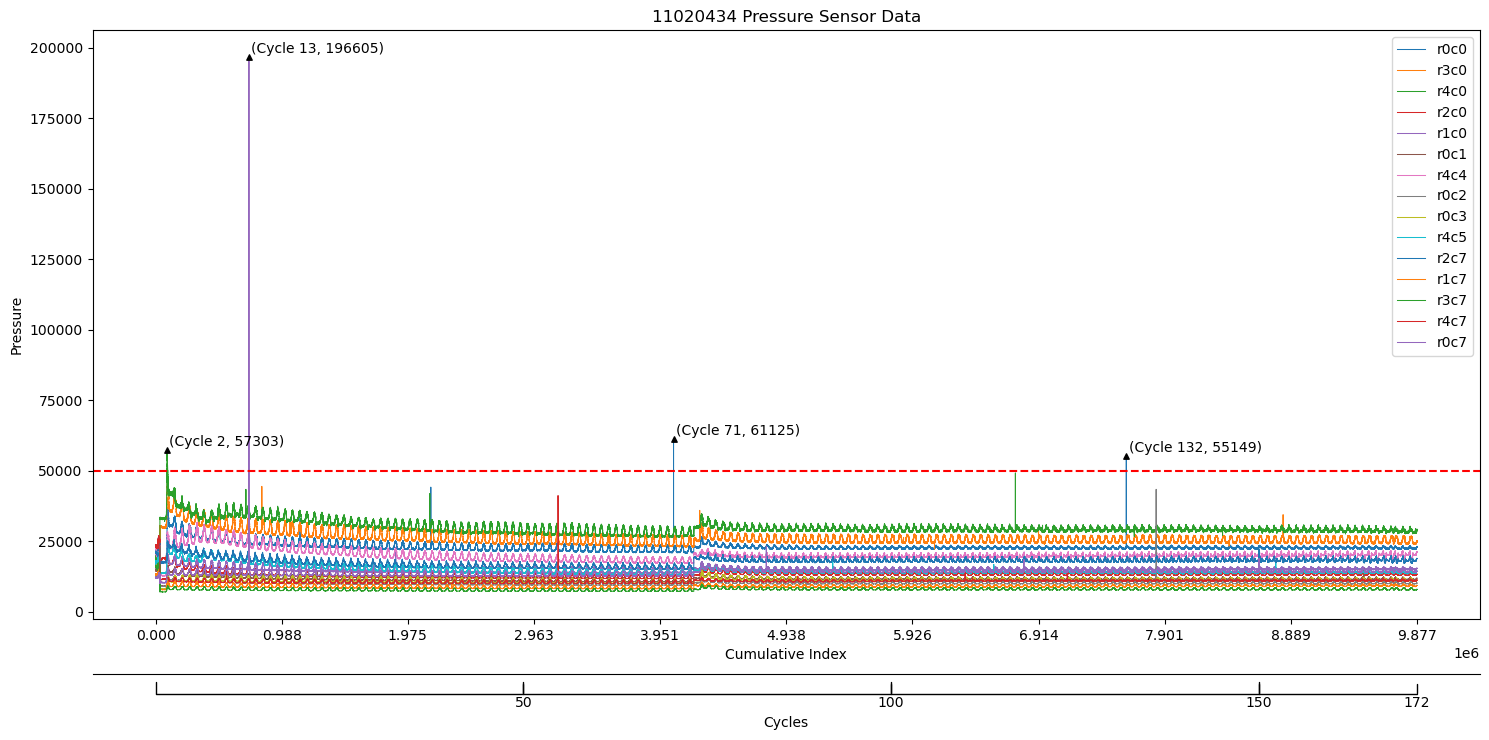

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.signal import find_peaks
import adjustText as at
plt.style.use('default')

plt.rcParams["figure.figsize"] = [15, 7.5]
plt.rcParams["figure.autolayout"] = True

def main():
    #-- Generate some data ----------------------------------------------------
    
    columns= ['Cumulative Index', 'r0c0','r3c0','r4c0','r2c0','r1c0', 'r0c1', 'r4c4', 'r0c2', 'r0c3', 'r4c5', 'r2c7', 'r1c7', 'r3c7', 'r4c7', 'r0c7']
    
    df=pd.read_csv('11020434_press.csv', dtype='int32')
    pf=df[columns]
    
    groups = getCycles(df)

    #-- Plot the results ------------------------------------------------------
    fig = plt.figure()
    ax = fig.add_subplot(111)

    # Give ourselves a bit more room at the bottom
    plt.subplots_adjust(bottom=0.2)

    pf.set_index('Cumulative Index', inplace=True)
    ax.plot(pf, label=['r0c0','r3c0','r4c0','r2c0','r1c0', 'r0c1', 'r4c4', 'r0c2', 'r0c3', 'r4c5', 'r2c7', 'r1c7', 'r3c7', 'r4c7', 'r0c7'], linewidth=0.75)
    # Drop the bottom spine by 40 pts
    ax.spines['bottom'].set_position(('outward', 0))

    # Make a second bottom spine in the position of the original bottom spine
    make_second_bottom_spine(label='Cycles')
    
    # Annotate the groups
    for name, xspan in groups:
        annotate_group(name, xspan)

    plt.xlabel('Cumulative Index')
    plt.xticks(df['Cumulative Index'][::len(df)//10])
    plt.ylabel('Pressure')
    plt.title('%s Pressure Sensor Data' %df['SN'][0])
    plt.axhline(y=50000, color='r', linestyle='--')
    plt.legend()
    get_lim(pf)
    plt.savefig('%s_press_graph.png' %df['SN'][0])
    plt.show()



def annotate_group(name, xspan, ax=None):
    """Annotates a span of the x-axis"""
    def annotate(ax, name, left, right, y, pad):
        arrow = ax.annotate(name,
                xy=(left, y), xycoords='data',
                xytext=(right, y-pad), textcoords='data',
                annotation_clip=False, verticalalignment='top',
                horizontalalignment='center', linespacing=1.0,
                arrowprops=dict(arrowstyle='-', shrinkA=0, shrinkB=0,
                        connectionstyle='angle,angleB=90,angleA=0,rad=0') #connectionstyle='angle,angleB=90,angleA=0,rad=10'
                )
        return arrow
    if ax is None: #Changes position of the arrows. Should work with ymin.
        ax = plt.gca()
    ymin = ax.get_ylim()[0]
    #print(ymin)
    ypad = 0.01 * np.ptp(ax.get_ylim())
    #print(ypad)
    #need an if condition below to only label 10'
    xcenter = xspan[1] #np.mean(xspan)
    left_arrow = annotate(ax, '', xspan[0], xcenter, -25000, ypad*2)
    right_arrow = annotate(ax, name, xspan[1], xcenter, -25500, ypad*2)
    return left_arrow, right_arrow #left_arrow, right_arrow

def make_second_bottom_spine(ax=None, label=None, offset=40, labeloffset=70): #Changes Date and the line of Date.
    """Makes a second bottom spine"""
    if ax is None:
        ax = plt.gca()
    second_bottom = mpl.spines.Spine(ax, 'bottom', ax.spines['bottom']._path)
    second_bottom.set_position(('outward', offset))
    ax.spines['second_bottom'] = second_bottom

    if label is not None:
        # Make a new xlabel
        ax.annotate(label, 
                xy=(0.5, 0), xycoords='axes fraction', 
                xytext=(0, -labeloffset), textcoords='offset points', 
                verticalalignment='top', horizontalalignment='center')

def getGroups(df):
    dup = df.drop_duplicates('Cycle #', keep='last')
    date_list = dup['Date'].tolist()
    index_list= dup['Cumulative Index'].tolist()
    
    groups = []
    start_index = 0
    for i in range(len(date_list)):
        last_index = index_list[i]
        groups.append((date_list[i], (start_index, last_index)))
        start_index = last_index + 1
    return groups

def getCycles(df):
    cycles = []
    start_index = 0
    cycle_count = 0
    while start_index < len(df):
        #checks if last_index exceeds the maximum index.
        if start_index + (57600*50-1) < len(df):
            last_index = start_index + (57600*50-1)
            cycle_count += 50
            cycles.append(('%i' % cycle_count , (start_index, last_index)))
            start_index = last_index + 1
        
        else:
            last_index = start_index + (len(df) - start_index)
            cycle_count += ceildiv((last_index - start_index), 57600)
            cycles.append(('%i' % cycle_count , (start_index, last_index)))
            start_index = last_index + 1
            
        
    return cycles

def ceildiv(a, b): #ceiling division function because python doesn't have an operator for it.
    return -(a // -b)

def obs_peaks(pf):
    maxlist = []
    idx_maxlist = []
    for i in range(1, len(pf.max())):
        maxlist.append(pf.max()[i])
        idx_maxlist.append(pf.idxmax()[i])
    plt.scatter(idx_maxlist, maxlist,s=15, marker='^', color='black', zorder=2)
    texts = [plt.text(idx_maxlist[i], maxlist[i], '(%i, %i)' % (idx_maxlist[i], maxlist[i]), ha='center', va='center') for i in range(len(maxlist))] ## REVISION NEEDED ##
    at.adjust_text(texts)    
    
def get_lim(df):
    s_columns=['r0c0','r3c0','r4c0','r2c0','r1c0', 'r0c1', 'r4c4', 'r0c2', 'r0c3', 'r4c5', 'r2c7', 'r1c7', 'r3c7', 'r4c7', 'r0c7']
    for colname in df[s_columns]:
        peaks = find_peaks(df[colname], height=50000, distance=100000)
        x = [peaks[0]]
        y = peaks[1]['peak_heights']
        if len(y) != 0:
            plt.scatter(x, y,s=15, marker='^', color='black', zorder=2)
            texts = [plt.text(x[0][i], y[i], '(Cycle %i, %i)' % (ceildiv(x[0][i], 57600), y[i]), ha='center', va='center') for i in range(len(y))] ## REVISION NEEDED ##
            at.adjust_text(texts)  
        
        
if __name__ == '__main__':
    main()